# Monte Carlo simulation of the folded incoherent noise distribution

One of the question that we have from our analysis is that the sky-subtracted incoherently-averaged (over antennas) noise spectrum (INS) of the MeerKLASS autocorrelation visibility does not produce the expected folded Gaussian distribution. This maybe caused by the fact that we do not have enough number of antennas. Specifically, the incoherent averaging over many baselines, or in our cases antennas, in the SSINS algorithm is what leads to the expected noise distribution following the central limit (CLT) theorem. This is derived for cross-correlation in Wilensky et al. (2019). As we only have ~60 antennas to average over, this may or may not be enough for the CLT to kick in. In attempt to figure this out, we will perform a simple Monte Carlo simulation by drawing from a folded Gaussian distribution (first with no mock RFI for simplicity) 60 times, averaged over the mock noise spectrum, and then look at the z-score distribution.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import foldnorm

First, set up a somewhat realistic observation parameters for the simulation. Since we are simulating noise, we do not have to be specific about the time and frequency dimentions, but the total number of data points matter.

In [2]:
nants = 60
ntimes = 2500
nfreqs = 4096
nsamples = ntimes * nfreqs

Now, draw from a folded Normal distribution into an array of shape Nants x Ntimes x Nfreqs to make a mock incoherent noise spectrum. Note that this is equivalent to the absolute value of the (perfectly) sky-subtracted autocorrrelation (with no RFI).

In [3]:
ins = np.zeros((nants, nsamples))
for i in range(nants):
    ins[i] = foldnorm.rvs(0, size=nsamples)

Plot one of the noise spectrum just to make sure that the distribution is folded normal

(array([4.320044e+06, 3.194943e+06, 1.748868e+06, 7.088060e+05,
        2.115570e+05, 4.715200e+04, 7.553000e+03, 9.720000e+02,
        9.800000e+01, 7.000000e+00]),
 array([2.80203463e-07, 5.56145775e-01, 1.11229127e+00, 1.66843677e+00,
        2.22458226e+00, 2.78072776e+00, 3.33687325e+00, 3.89301875e+00,
        4.44916424e+00, 5.00530974e+00, 5.56145523e+00]),
 <BarContainer object of 10 artists>)

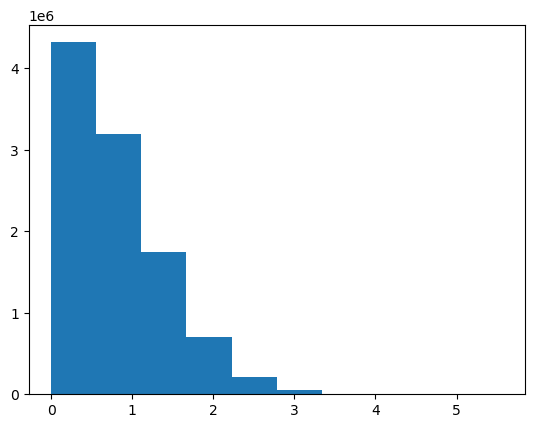

In [4]:
plt.hist(ins[0])

Average over antennas (1st axis) to produce the incoherntly-averaged noise spectrum

In [5]:
ins_average = ins.mean(axis=0)

Now, calculate and plot the z-score, making sure we have the right normalisation when doing so

Some summary and conclusion here ...